In [1]:
#RNN  -   Generate the text (Tensorflow tutorial)
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
path_to_file = tf.keras.utils.get_file('/content/drive/MyDrive/Data/shakespeare.txt', 'https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt')
text = open(path_to_file, 'rb').read().decode(encoding='utf-8')
print(f'Length of text: {len(text)} characters')

Length of text: 1115394 characters


In [3]:
# The unique characters in the file
vocab = sorted(set(text))
print(f'{len(vocab)} unique characters')

65 unique characters


In [4]:
ids_from_chars = tf.keras.layers.StringLookup(
    vocabulary=list(vocab), mask_token=None)

In [5]:
chars_from_ids = tf.keras.layers.StringLookup(
    vocabulary=ids_from_chars.get_vocabulary(), invert=True, mask_token=None)

In [6]:
def text_from_ids(ids):
  return tf.strings.reduce_join(chars_from_ids(ids), axis=-1)

In [7]:
#use the function to convert text to ids
all_ids = ids_from_chars(tf.strings.unicode_split(text, 'UTF-8'))

In [8]:
#transform to tensor
ids_dataset = tf.data.Dataset.from_tensor_slices(all_ids)

In [9]:
seq_length = 100
sequences = ids_dataset.batch(seq_length+1, drop_remainder=True)
for seq in sequences.take(5):
  print(text_from_ids(seq).numpy())

b'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '
b'are all resolved rather to die than to famish?\n\nAll:\nResolved. resolved.\n\nFirst Citizen:\nFirst, you k'
b"now Caius Marcius is chief enemy to the people.\n\nAll:\nWe know't, we know't.\n\nFirst Citizen:\nLet us ki"
b"ll him, and we'll have corn at our own price.\nIs't a verdict?\n\nAll:\nNo more talking on't; let it be d"
b'one: away, away!\n\nSecond Citizen:\nOne word, good citizens.\n\nFirst Citizen:\nWe are accounted poor citi'


In [10]:
#output first to n-1, and second to n, which n = length of sequence
def split_input_target(sequence):
    input_text = sequence[:-1]
    target_text = sequence[1:]
    return input_text, target_text

In [11]:
dataset = sequences.map(split_input_target)

In [12]:
for input_example, target_example in dataset.take(1):
    print("Input :", text_from_ids(input_example).numpy())
    print("Target:", text_from_ids(target_example).numpy())

Input : b'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou'
Target: b'irst Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '


In [13]:
# Batch size
BATCH_SIZE = 64
# Buffer size
BUFFER_SIZE = 10000

dataset = (
    dataset
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.experimental.AUTOTUNE))

In [14]:
# Length of the vocabulary in StringLookup Layer
vocab_size = len(ids_from_chars.get_vocabulary())

# The embedding dimension
embedding_dim = 256

# Number of RNN units
rnn_units = 1024

In [15]:
class GRUmodel(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, rnn_units):
    super().__init__(self)
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(rnn_units,
                                   return_sequences=True,
                                   return_state=True)
    self.dense = tf.keras.layers.Dense(vocab_size)

  def call(self, inputs, states=None, return_state=False, training=False):
    x = inputs
    x = self.embedding(x, training=training)
    if states is None:
      states = self.gru.get_initial_state(x)
    x, states = self.gru(x, initial_state=states, training=training)
    x = self.dense(x, training=training)

    if return_state:
      return x, states
    else:
      return x

In [16]:
model = GRUmodel(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    rnn_units=rnn_units)

In [17]:
for input_example_batch, target_example_batch in dataset.take(1):
    example_batch_predictions = model(input_example_batch)
    print(example_batch_predictions.shape)

(64, 100, 66)


In [18]:
model.summary()

Model: "gr_umodel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       multiple                  16896     
                                                                 
 gru (GRU)                   multiple                  3938304   
                                                                 
 dense (Dense)               multiple                  67650     
                                                                 
Total params: 4,022,850
Trainable params: 4,022,850
Non-trainable params: 0
_________________________________________________________________


In [19]:
loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True)
example_batch_mean_loss = loss(target_example_batch, example_batch_predictions)
print("Prediction shape: ", example_batch_predictions.shape, " # (batch_size, sequence_length, vocab_size)")
print("Mean loss:        ", example_batch_mean_loss)

Prediction shape:  (64, 100, 66)  # (batch_size, sequence_length, vocab_size)
Mean loss:         tf.Tensor(4.190904, shape=(), dtype=float32)


In [20]:
model.compile(optimizer='adam', loss=loss)

In [21]:
# Directory where the checkpoints will be saved
checkpoint_dir = '/content/drive/MyDrive/MLh5'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

In [22]:
EPOCHS = 20
history = model.fit(dataset, epochs=EPOCHS, callbacks=[checkpoint_callback])

Epoch 1/20
172/172 [==============================] - 12s 52ms/step - loss: 2.7251
Epoch 2/20
172/172 [==============================] - 10s 52ms/step - loss: 1.9938
Epoch 3/20
172/172 [==============================] - 10s 52ms/step - loss: 1.7206
Epoch 4/20
172/172 [==============================] - 10s 53ms/step - loss: 1.5606
Epoch 5/20
172/172 [==============================] - 10s 53ms/step - loss: 1.4620
Epoch 6/20
172/172 [==============================] - 11s 54ms/step - loss: 1.3940
Epoch 7/20
172/172 [==============================] - 11s 55ms/step - loss: 1.3416
Epoch 8/20
172/172 [==============================] - 11s 55ms/step - loss: 1.2972
Epoch 9/20
172/172 [==============================] - 11s 55ms/step - loss: 1.2577
Epoch 10/20
172/172 [==============================] - 11s 55ms/step - loss: 1.2192
Epoch 11/20
172/172 [==============================] - 11s 54ms/step - loss: 1.1819
Epoch 12/20
172/172 [==============================] - 10s 54ms/step - loss: 1.1432
E

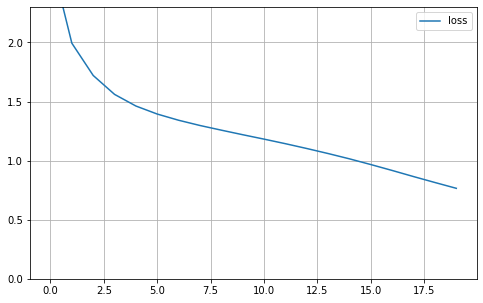

In [23]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 2.3) # set the vertical range to [0-1]
plt.show()